In [1]:
# Set up environment

import csv

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import copy


# B) Tell us about the data. How many samples are there in the training set? How many features? Which features are categorical?

In [2]:
def load_data(path):
    return pd.read_csv(path)



In [3]:
data_set = load_data('./house-prices-advanced-regression-techniques/train.csv')
test_set = load_data('./house-prices-advanced-regression-techniques/test.csv')

print("The shape of the training set is " + str(data_set.shape))
print(test_set.shape)

print("There are : " + str(data_set.shape[0]) + " instances ")
print("There are : " + str(data_set.shape[1] - 2) + " features")
print("")

print("The features are : " + str(data_set.columns))

categorical_vars = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
               'LotShape', 'LandContour', 'Utilities', 'LotConfig',
               'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
               'BldgType','HouseStyle','RoofStyle', 'RoofMatl',
               'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
               'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
               'GarageFinish','GarageQual', 'GarageCond', 'PavedDrive',
               'PoolQC', 'Fence', 'MiscFeature','SaleType', 'SaleCondition']


numeric_vars = [var for var in data_set.columns
                if var not in categorical_vars + ['Id', 'SalePrice']]

print("")

print("The categorical features are: " + str(categorical_vars))



The shape of the training set is (1460, 81)
(1459, 80)
There are : 1460 instances 
There are : 79 features

The features are : Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',

We see that the first column is id and last is sale price so we remove those from the feature set.

Therefore, there are 1460 instances and 79 total features


# C) What variables seem to be important? Which seem to correlate with the sale price? Plot the relationship between sale price and year of sale, garage area, lot area, and other variables of your choice. Choose 7 variables and, along with the response variable, make a scatterplot matrix (hint: look at pandas.plotting.scatter_matrix or seaborn.pairplot). Explain what you see

In [4]:
# Transform dataset to account for the categorical variables. For this assignment,
# we will just one hot encode these categorical variables
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def transform_features(features, categorical_features,
                       numeric_features, drop_features,
                       clf = None):
    
    # Drop all irrelevant features
    if clf == None:
        
        transformed_features = features.drop(drop_features, axis = 1)
        # Get transformers
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore',
                                     sparse = False)),
            ('scaler', StandardScaler())])

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())])


        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])

        clf = Pipeline(steps=[('preprocessor', preprocessor)])
    
        dataset = np.array(clf.fit_transform(transformed_features))
    else:
        transformed_features = features.drop(['Id'], axis = 1)
        dataset = np.array(clf.transform(transformed_features))
 
    # And get the new feature names:
    one_hot_names = clf.named_steps['preprocessor'].transformers_[1][1]\
           .named_steps['onehot'].get_feature_names(categorical_features)

    full_feature_names = np.array(list(numeric_features) + list(one_hot_names))
    
    
#     # Now drop duplicate features
#     dataset, unique_indices = np.unique(dataset, axis=1, return_index = True)
#     full_feature_names = full_feature_names[unique_indices]

    return dataset, full_feature_names, clf

    

In [5]:
# C) What variables seem to be important? Which seem to correlate with the sale price? Plot the relationship between sale price and year of sale, garage area, lot area, and other variables of your choice. Choose 7 variables and, along with the response variable, make a scatterplot matrix (hint: look at pandas.plotting.scatter_matrix or seaborn.pairplot). Explain what you see
from scipy.stats import pearsonr

def score_features(features, target, feature_names):
    feature_count = np.shape(features)[1]
    
    corrs = []
    
    weak_features = 0
    
    for i in range(feature_count):
        pvalue = pearsonr(target, features[:,i])[1]
        corrs.append(pvalue)
        
        if pvalue >= .05:
            weak_features += 1
    
    # Top 20 features:
    top_features = np.argsort(corrs)[:15]
    
    print("The top features are: ")

    
    for f in top_features:
        name = feature_names[f]
        print("Feature: " + str(name) + " P-value " + str(corrs[f]))
        
    print("")
    print("There were " + str(weak_features) + " that had a p value over .05")
        


The top features are: 
Feature: OverallQual P-value 2.185675268e-313
Feature: GrLivArea P-value 4.518033646780971e-223
Feature: GarageCars P-value 2.4986441671792262e-169
Feature: GarageArea P-value 5.2650381679802e-158
Feature: TotalBsmtSF P-value 9.484229391507914e-152
Feature: 1stFlrSF P-value 5.394710618971284e-147
Feature: ExterQual_TA P-value 4.309567397276831e-137
Feature: FullBath P-value 1.236470066760862e-121
Feature: BsmtQual_Ex P-value 9.157709122351054e-118
Feature: TotRmsAbvGrd P-value 2.772280932958432e-108
Feature: YearBuilt P-value 2.9902290990152195e-103
Feature: KitchenQual_TA P-value 1.2856089420584662e-101
Feature: YearRemodAdd P-value 3.1649482419200737e-96
Feature: KitchenQual_Ex P-value 6.256631383362451e-95
Feature: Foundation_PConc P-value 3.12470351099028e-92

There were 122 that had a p value over .05


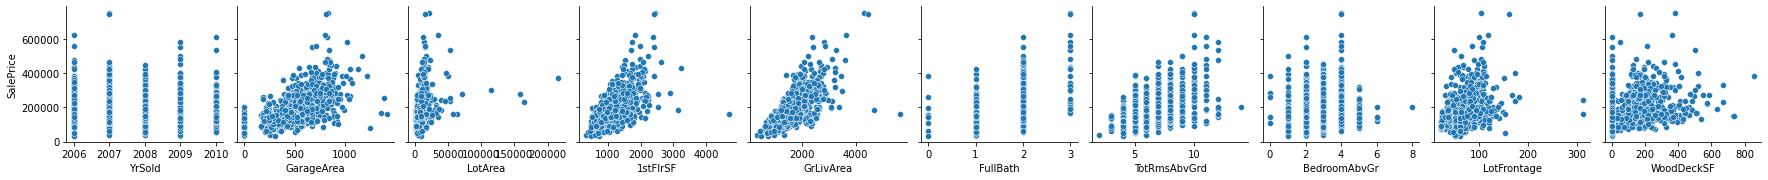

In [6]:
import seaborn as sns

drop_vars  = ['Id','SalePrice']

# First transform the features
features, feature_names, clf = transform_features(
    data_set, categorical_vars, numeric_vars, drop_vars)

test_features, test_names, clf = transform_features(
    test_set, categorical_vars, numeric_vars, drop_vars, clf = clf)

target = data_set['SalePrice']

score_features(features, target, feature_names)

important_features = ['YrSold', 'GarageArea', 'LotArea',
                      '1stFlrSF', 'GrLivArea', 'FullBath',
                      'TotRmsAbvGrd', 'BedroomAbvGr',
                      'LotFrontage', 'WoodDeckSF','SalePrice']

important_data = data_set[important_features]

important_features = important_features[:-1]


g = sns.pairplot(
    important_data,
    x_vars= important_features,
    y_vars=['SalePrice'],
)




Looking at the charts above, we see that some of the features that we would think would have a very strong correlation tend to breakdown because they are skewed or have high outliers. These variables include lot frontage and bedroom above grade. However, other varaibles such as overall quality of the house and living room area are very important. Many features seem rather uncorrelated as standalone variables (maybe scaling or transforming it differently could unlock their value).

# D) (optional) Using statsmodels, run ordinary least squares on all the features and report which features have a 95% confidence interval that contains 0 and which do not. Comment on what this means.

In [7]:
import statsmodels.api as sm

trans_features = np.array(features)
trans_features = sm.add_constant(trans_features)

trans_target = np.array(target)

results = sm.OLS(endog= trans_target, exog= trans_features).fit()

full_names = [1] + list(feature_names)

# Get lowest p values
feature_p_values = results.pvalues

bad_features = [full_names[i] for i in
                range(len(feature_p_values))
                if feature_p_values[i] > .05]
good_features = [name for name in full_names
                 if name not in bad_features]

print("")
print("Bad features: p value > .05")
print(bad_features)
print(len(bad_features))
print("")
print("Good features: p value <= 0.05")
print(good_features)
print(len(good_features))
        



Bad features: p value > .05
['LotFrontage', 'YearRemodAdd', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_Grvl', 'Alley_Pave', 'Alley_nan', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood

Features that have a p value lower than .05 are features that have a 95% confidence interval that does not contain 0. These features make us reject the hypothesis that this feature has no impact on the target.

#  E) Split the training data into a training (80%) and test set (20%). Try to run a variety of regression methods using sklearn methods:

# Ordinary least squares

# k-Nearest Neighbors with 10-fold cross validation to choose k

# Ridge regression with 10-fold cross validation to chose λ

# LASSO with 10-fold cross validation to chose λ

# Backward stepwise (linear) regression with 10-fold cross validation to choose k (number of features)

# Forward stepwise (linear) regression with 10-fold cross validation to choose k (number of features)

# Since each feature in this dataset is measured in completely different units and dimensions (e.g., LotArea vs LotFrontage), make sure that for regularized models (ridge and LASSO) you standardize your data first so that coefficients of smaller units are not unfairly penalized relative to coefficients of bigger units (hint: use sklearn.preprocessing.StandardScaler).

# (Extra hint: sklearn also has methods called RidgeCV and LassoCV.)

# For each, give a brief description of how well it works and why that might be and report the test accuracy (note: this refers to split off test set above; not the Kaggle test set).

In [8]:
def OLS(features, target, test_features):
    
    model = LinearRegression().fit(features, target)
    
    return model.predict(test_features)
    
    

In [9]:
# implement KNN with CV over 

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

def KNN(features, target, test_features,
        cv = 10):
    
    # Try n between 1 and 25
    grid_params = {'n_neighbors': [i+1 for i in range(15)]}
    
    # Implement grid search with k fold given by cv param
    
    gs = GridSearchCV(KNeighborsRegressor(),
                      grid_params,
                      cv = 10)
    
    gs.fit(features, target)
    
    print("The optimal k is " + str(gs.best_params_))
    
    return gs.predict(test_features)
    
    

In [10]:
# Implement Lasso AND Ridge by setting 1_ratio param.
# As stated on sklearn's docs, 1_ratio = 1 is lasso
# And l_ratio = 2 is Ridge

from sklearn.linear_model import RidgeCV, LassoCV

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def ridge_regression(features, target,
                       test_features,
                       cv = 10,
                       alpha = [.1,.5,1,2,5,10]):
    
    model = RidgeCV(alphas = alpha, cv = 10)
    
    model.fit(features,target)
    print("The alpha regularization param is " + str(model.alpha_))
    
    return model.predict(test_features)
    
def lasso_regression(features, target,
                       test_features,
                       cv = 10,
                       alpha = [.1,.5,1,2,5,10]):
    
    model = LassoCV(alphas = alpha, cv = 10)
    
    model.fit(features,target)
    print("The alpha regularization param is " + str(model.alpha_))
    
    features_used = []
    for c in range(len(model.coef_)):
        if abs(model.coef_[c]) > 0.01:
            features_used.append(c)
        
            
    
    return model.predict(test_features), features_used

In [11]:
# Backward stepwise (linear) regression with 10-fold
# cross validation to choose k (number of features)
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

def backwards_regressor(features, target,
                      test_features):

    total_features = len(features[0])
    feature_list = [i for i in range(total_features)]
    
    best_score = [0,0]
    
    best_details = [[],0,0]
    
    model = LinearRegression()
    
    for i in range(total_features, 1, -1):
        
        trial_features = features[:, feature_list]
        
        # Want to get the worst (highest) p value of the remaining features

        feature_p_values = f_regression(trial_features,
                                        target,
                                        center = False)[1]
        worst_feature = feature_list[
            np.argmax(feature_p_values)]
        
        # Remove worst feature from feature list
        feature_list.remove(worst_feature)
        
        # Now run CV to get average and sigma of R2 scores
        trial_features = features[:, feature_list]
        
        cv_results = cross_validate(model,
                                    trial_features,
                                    target, cv=10)
        
        test_results = cv_results['test_score']

        model_acc = np.average(test_results)
        model_sigma = np.std(test_results)
        
        # Update very best model in terms of r22
        if model_acc > best_score[0]:
            best_score = [model_acc, model_sigma]
            
        # Check if this model is within 1 sigma of the very best
        if model_acc > best_score[0] - best_score[1]:
            best_details = [copy.deepcopy(feature_list),
                            model_acc, model_sigma]
  
            
    [feature_set, model_acc, model_sigma] = best_details

    model = LinearRegression().fit(
        features[:,feature_set], target)

    print("Got the best result with k = " + str(len(feature_set)))
    print("Features: " + str(feature_set))
    print("Average CV R2: " + str(model_acc))
    
    test_data = test_features[:, feature_set]
    
    test_preds = model.predict(test_data)
    
    return test_preds, feature_set

    


In [12]:
# Forward stepwise (linear) regression with 10-fold
# cross validation to choose k (number of features).
# Stops when R2 score stops increasing
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

def forwards_regressor(features, target, test_features):

    total_features = len(features[0])
    feature_list = [i for i in range(total_features)]
    
    used_features = []
    
    best_score = [0,0]
    
    model_size_details = {}
    
    model = LinearRegression()
    
    
    improvement_made = True
    

    while improvement_made == True:
        
        step_feature = -1

        for f in feature_list:
            if f not in used_features:
                trial_list = copy.deepcopy(used_features)
                trial_list.append(f)
                
                # Now run CV to get average and sigma of R2 scores
                trial_features = features[:, trial_list]
                
                cv_results = cross_validate(model,
                                            trial_features,
                                            target, cv=10)
        
                test_results = cv_results['test_score']

                model_acc = np.average(test_results)
                model_sigma = np.std(test_results)
                
                if model_acc > best_score[0]:
                    step_feature = f
                    best_score = [model_acc, model_sigma]
                    
    
        if step_feature == -1:
            improvement_made = False
        else:
            used_features.append(step_feature)
            feature_count = len(used_features)
            model_size_details[feature_count] = [
                copy.deepcopy(used_features), model_acc, model_sigma]
            
    
    best_index = -1
    
    for k in model_size_details:
        [feature_set, model_acc,
         model_sigma] = model_size_details[k]
        
        if model_acc > best_score[0] - best_score[1]:
            if k <= best_index or best_index == -1:
                best_index = k
            
    [feature_set, model_acc, model_sigma] = model_size_details[best_index]
    
    model = LinearRegression().fit(features[:,feature_set], target)

    # Best model accuaracy score
    print("Got the best result with k = " + str(len(feature_set)))
    print("Features: " + str(feature_set))
    print("Average CV R2: " + str(model_acc))
    
    test_data = test_features[:, feature_set]
    
    test_preds = model.predict(test_data)
    
    return test_preds, feature_set

In [13]:
def run_regression_models(train_data, test_data,
                          feature_names, model_types,
                         print_features = False,
                          return_preds = False):

    [X_train, y_train] = train_data
    [X_test, y_test] = test_data
    
    for model in model_types:

        print("")
        print("Running model " + str(model))
        
        features_used = []

        if model == 'OLS':
            y_preds = OLS(X_train, y_train, X_test)

        elif model == 'KNN':
            y_preds = KNN(X_train, y_train, X_test, cv = 10)

        elif model == 'ridge':
            y_preds = ridge_regression(X_train, y_train,
                                         X_test,
                                         cv = 10)

        elif model == 'lasso':
            y_preds, features_used = lasso_regression(X_train,
                                                      y_train,
                                         X_test,
                                         cv = 10)
            
        elif model == 'backward':
            y_preds, features_used = backwards_regressor(X_train,
                                                         y_train, X_test)

        elif model == 'forward':
            y_preds, features_used = forwards_regressor(X_train,
                                                        y_train, X_test)

        else:
            continue

        if features_used != [] and print_features == True:
            print("Feature count: " + str(len(features_used)))
            print("Used features: " + str(feature_names[features_used]))
            
        if return_preds == False:
            test_r2 = r2_score(y_test, y_preds)
            print("The test r2 score is " + str(test_r2))
        else:
            return y_preds
    
    


In [14]:
# Split the training set
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

model_types = ['OLS','KNN','ridge','lasso','forward','backward']

features = np.array(features, dtype=float)
target = np.array(target, dtype=float)


# First split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

train_data = [X_train, y_train]    
test_data = [X_test, y_test]
    
run_regression_models(train_data, test_data, feature_names, model_types)




Running model OLS
The test r2 score is -1.954129681867452e+22

Running model KNN
The optimal k is {'n_neighbors': 10}
The test r2 score is 0.7476396828530416

Running model ridge
The alpha regularization param is 1.0
The test r2 score is 0.8860776662987806

Running model lasso
The alpha regularization param is 5.0
The test r2 score is 0.8865794770596603

Running model forward
Got the best result with k = 9
Features: [2, 14, 198, 24, 15, 35, 139, 20, 246]
Average CV R2: 0.8102389231935188
The test r2 score is 0.8328546972855506

Running model backward
Got the best result with k = 4
Features: [2, 14, 141, 243]
Average CV R2: 0.6941835759726855
The test r2 score is 0.7457643057171446


# F) Repeat the above, except for OLS, after adding all the quadratic features: Xi j Xi k for all j,k = 1,...,p (this includes X2 i j). (Backward/forward stepwise regression are optional).

In [15]:
# Expand features to a higher degree. We ignore any
from sklearn.preprocessing import PolynomialFeatures

def expand_degree(features, feature_names, degree = 2):
    
    
    poly = PolynomialFeatures(degree)
    expanded_features = poly.fit_transform(features)
    
    expanded_names = np.array(poly.get_feature_names(feature_names))
    
    expanded_features, unqiue_indices = np.unique(expanded_features,
                                            axis=1,
                                            return_index = True)
    
    expanded_names = expanded_names[unqiue_indices]
    
    return expanded_features, expanded_names

    

In [16]:

# Exlude OLS, Backward and Forward
model_types = ['KNN','ridge','lasso']

# Expand the feature set to include quadratic features
expanded_features, expanded_names = expand_degree(np.array(features),
                                                  feature_names,
                                                  degree = 2)


# First split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(expanded_features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

train_data = [X_train, y_train]    
test_data = [X_test, y_test]
    

run_regression_models(train_data, test_data,
                      expanded_names, model_types)


Running model KNN
The optimal k is {'n_neighbors': 3}
The test r2 score is 0.631178705673061

Running model ridge
The alpha regularization param is 10.0
The test r2 score is 0.825381711107942

Running model lasso
The alpha regularization param is 10.0
The test r2 score is 0.8727234210715225


# G) Which variables are being retained by LASSO and the stepwise regression models and which are regularized away? Do these variables match your intuitions about which variables are important and which are not? Compare this to (d).

In [17]:

model_types = ['lasso','forward','backward']

# First split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

train_data = [X_train, y_train]    
test_data = [X_test, y_test]
    
    
preds = run_regression_models(train_data, test_data,
                      feature_names, model_types,
                      print_features = True)



Running model lasso
The alpha regularization param is 5.0
Feature count: 266
Used features: ['LotFrontage' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'GarageCars'
 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold' 'MSSubClass_30'
 'MSSubClass_40' 'MSSubClass_45' 'MSSubClass_50' 'MSSubClass_60'
 'MSSubClass_70' 'MSSubClass_75' 'MSSubClass_80' 'MSSubClass_85'
 'MSSubClass_90' 'MSSubClass_120' 'MSSubClass_160' 'MSSubClass_190'
 'MSZoning_C (all)' 'MSZoning_FV' 'MSZoning_RH' 'Street_Grvl' 'Alley_Pave'
 'Alley_nan' 'LotShape_IR1' 'LotShape_IR2' 'LotShape_IR3'
 'LandContour_Bnk' 'LandContour_HLS' 'LandContour_Low' 'Utilities_AllPub'
 'LotConfig_Corner' 'LotConf

# F) Train your best-performing classifier with all of the training data, and generate test labels on the Kaggle test set. Submit your results to Kaggle and report the accuracy. Is it higher or lower than the cross validation accuracy? Why might that happen? Is it higher or lower than the held-out validation accuracy? Why might that happen?

In [18]:
# Use the lasso model

preds = run_regression_models([features, target], [test_features,[]],
                  feature_names, ['lasso'],
                  return_preds = True)

with open('jw_submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    header = ['Id','SalePrice']
    
    writer.writerow(header)
    
    for i in range(len(preds)):
        writer.writerow([1461+i, preds[i]])
        
        
        


Running model lasso
The alpha regularization param is 10.0


We got a score of .192 (jwTester submission) which is lower than the cv test result and the test result. This is probably because this data is brand new and we did not standardize or prep our data using these features.

